In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import random_split
from torchsummary import summary
import time
import numpy as np

In [2]:
pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [28]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, dropout=0.5, num_channels=[32, 64, 128, 256], avg_pool_kernel_s=4, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.avg_pool_kernel_s = avg_pool_kernel_s
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        layers = []
        for i, num_blocks_in_layer in enumerate(num_blocks):
            stride = 1 if i == 0 else 2
            layers.append(nn.Dropout2d(p=dropout))
            layers.append(self._make_layer(block, num_channels[i], num_blocks_in_layer, stride=stride))
        self.layers = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1] * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, self.avg_pool_kernel_s)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# If GPU available, the code uses it. Otherwise cpu is used for the training (not recommended).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:
torch.manual_seed(42)
BATCH_SIZE_TRAIN = 200
BATCH_SIZE_TEST = 1000
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
     

Files already downloaded and verified
Files already downloaded and verified


In [30]:
total_size = len(trainset)
train_size = int(0.9 * total_size)
validation_size = total_size - train_size

# Split the dataset
generator = torch.Generator().manual_seed(42)
trainset, validationset = torch.utils.data.random_split(trainset, [train_size, validation_size], generator)

In [31]:
def train_transform():
    return transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform()),
    batch_size=BATCH_SIZE_TRAIN, shuffle=True, num_workers=2, pin_memory=True)

test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE_TEST, shuffle=False, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validationset, batch_size=BATCH_SIZE_TRAIN, shuffle=False, num_workers=1)


Files already downloaded and verified


In [32]:
def train_epoch(model, optimizer, scheduler, data_loader, loss_history, criterion):
  total_samples = len(data_loader.dataset)
  model.train()
  for i, (data, target) in enumerate(data_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
      print('[' + '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
      ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)] Loss: ' +
      '{:6.4f}'.format(loss.item()))
  loss_history.append(loss.item())
  scheduler.step()

In [33]:
def evaluate(model, data_loader, loss_history, criterion):
  model.eval()
  total_samples = len(data_loader.dataset)
  correct_samples = 0
  losses = []
  with torch.no_grad():
    for data, target in data_loader:
      data = data.to(device)
      target = target.to(device)
      output = model(data)
      loss = criterion(output, target)
      _, pred = torch.max(output, dim=1)

      losses.append(loss.item())
      correct_samples += pred.eq(target).sum()

  avg_loss = np.mean(losses)
  loss_history.append(avg_loss)
  print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
  ' Accuracy:' + '{:5}'.format(correct_samples) + '/' + '{:5}'.format(total_samples) + ' (' +
  '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [40]:
num_epochs = 100
model = ResNet(BasicBlock, [1, 1, 1, 1], num_channels=[64, 128,256, 512], avg_pool_kernel_s=4, num_classes=10)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.00001)
criterion = nn.CrossEntropyLoss()
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         Dropout2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           9,216
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8           [-1, 64, 32, 32]           1,024
       BatchNorm2d-9           [-1, 64, 32, 32]             128
       BasicBlock-10           [-1, 64, 32, 32]               0
        Dropout2d-11           [-1, 64, 32, 32]               0
           Conv2d-12          [-1, 128, 16, 16]          73,728
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1, 128,

In [41]:
best_val_loss = np.inf  # Track the highest validation accuracy

start_time = time.time()
train_loss_history, valid_loss_history = [], []
termination_count = 0 #If valid loss does not decrease in 5 consecutive epochs terminate the training
for epoch in range(1, num_epochs + 1):
  print('Epoch:', epoch)
  train_epoch(model, optimizer, scheduler, train_loader, train_loss_history, criterion)
  evaluate(model, validation_loader, valid_loss_history, criterion)
  if valid_loss_history[-1] < best_val_loss:
  #Save the best model in terms of validation loss.
    torch.save(model.state_dict(), 'best_model.pth')
    best_val_loss = valid_loss_history[-1]
    termination_count = 0
  else:
    termination_count = termination_count + 1
  if termination_count >= 5:
    break
print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/50000 (  0%)] Loss: 2.3250
[20000/50000 ( 40%)] Loss: 2.1172
[40000/50000 ( 80%)] Loss: 1.9602

Average test loss: 1.8786 Accuracy: 1562/ 5000 (31.24%)

Epoch: 2
[    0/50000 (  0%)] Loss: 1.9607
[20000/50000 ( 40%)] Loss: 1.8827
[40000/50000 ( 80%)] Loss: 1.9040

Average test loss: 1.7675 Accuracy: 1865/ 5000 (37.30%)

Epoch: 3
[    0/50000 (  0%)] Loss: 1.7873
[20000/50000 ( 40%)] Loss: 1.7309
[40000/50000 ( 80%)] Loss: 1.6966

Average test loss: 1.6366 Accuracy: 2057/ 5000 (41.14%)

Epoch: 4
[    0/50000 (  0%)] Loss: 1.6985
[20000/50000 ( 40%)] Loss: 1.7192
[40000/50000 ( 80%)] Loss: 1.7178

Average test loss: 1.6189 Accuracy: 2142/ 5000 (42.84%)

Epoch: 5
[    0/50000 (  0%)] Loss: 1.6541
[20000/50000 ( 40%)] Loss: 1.5674
[40000/50000 ( 80%)] Loss: 1.5339

Average test loss: 1.5399 Accuracy: 2306/ 5000 (46.12%)

Epoch: 6
[    0/50000 (  0%)] Loss: 1.5618
[20000/50000 ( 40%)] Loss: 1.4639
[40000/50000 ( 80%)] Loss: 1.3914

Average test loss: 1.4221 Accuracy: 2449/ 5

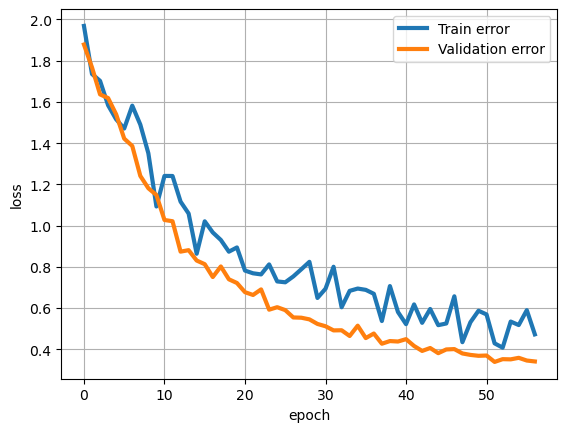

In [42]:
import matplotlib.pyplot as plt
plt.plot(train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(valid_loss_history,'-',linewidth=3,label='Validation error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
%matplotlib inline
plt.show()

In [43]:
evaluate(model, test_loader, [], criterion)


/home/ap8130/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Average test loss: 0.4698 Accuracy: 8427/10000 (84.27%)

